# Part 1: Exploratory Data Analysis 

The attached logins.json file contains (simulated) timestamps of user logins in a particular
geographic location. Aggregate these login counts based on 15minute
time intervals, and
visualize and describe the resulting time series of login counts in ways that best characterize the
underlying patterns of the demand. Please report/illustrate important features of the demand,
such as daily cycles. If there are data quality issues, please report them.

In [1]:
# Import necessary libraries 
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels as sm
import numpy as np
from datetime import datetime
%matplotlib inline
import seaborn as sns
from scipy.stats import randint

In [2]:
#read data
df = pd.read_json('logins.json')
df

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21
...,...
93137,1970-04-13 18:50:19
93138,1970-04-13 18:43:56
93139,1970-04-13 18:54:02
93140,1970-04-13 18:57:38


In [3]:
# Confirm column is a datetime object
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93142 entries, 0 to 93141
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   login_time  93142 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 727.8 KB


#### Aggregate the Data

In [4]:
# Aggregate and resample based on 15 minute interval
df.login_time = pd.to_datetime(df.login_time)#convert to datetime object
df.index = (df.login_time) # set datetime as index
df['login'] = 1 #count each observation as an instance
df = df.resample('15Min').sum() #aggregate as the sum of instances over 15 min
df = df.fillna(0) #fill missing values as zero to indicate no logins during that interval

In [5]:
df

,login
login_time,
1970-01-01 20:00:00,2
1970-01-01 20:15:00,6
1970-01-01 20:30:00,9
1970-01-01 20:45:00,7
1970-01-01 21:00:00,1
...,...
1970-04-13 17:45:00,5
1970-04-13 18:00:00,5
1970-04-13 18:15:00,2


#### Visualize the data 

In [6]:
# See if there is any missing values
df.isnull().sum()

login    0
dtype: int64

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9788 entries, 1970-01-01 20:00:00 to 1970-04-13 18:45:00
Freq: 15T
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   login   9788 non-null   int64
dtypes: int64(1)
memory usage: 152.9 KB


The range of dates is from January 1st of 1970 to April 13th 1970.


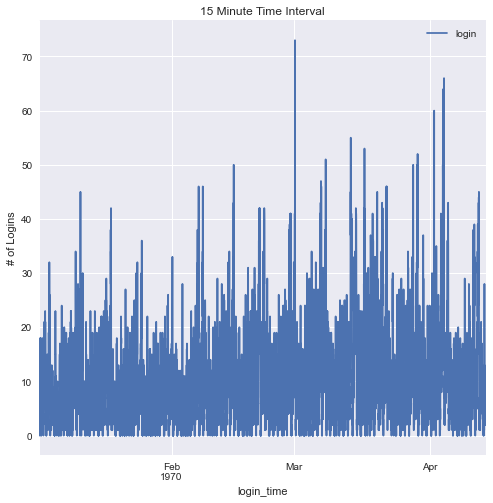

In [8]:
#Visulaize all of th data
plt.style.use('seaborn')
df.plot(figsize=(8,8))
plt.title('15 Minute Time Interval')
plt.ylabel('# of Logins')
plt.show()

We can't get a clear picture of demand from the plot above, other than demand rises with what looks like a constant period. Let's try  smoothing the data out and see what we find. 

In [9]:
def resample(df, interval):
    """
    Takes a dataframe and time interval to resample into
    
    Returns resampled dataframe
    """
    # resample the dataframe 
    temp_resample = df.resample(interval).sum()
    return temp_resample


def custom_plot(df, axis, title, y_label=''):
    """
    Arguments:
    df: A dataframe
    axis: location of subplot
    title: title of subplot
    y_label: y label of subplot
    """
    plt.subplot(axis)
    plt.plot(df)
    plt.ylabel(y_label)
    plt.title(title)
    plt.tight_layout()

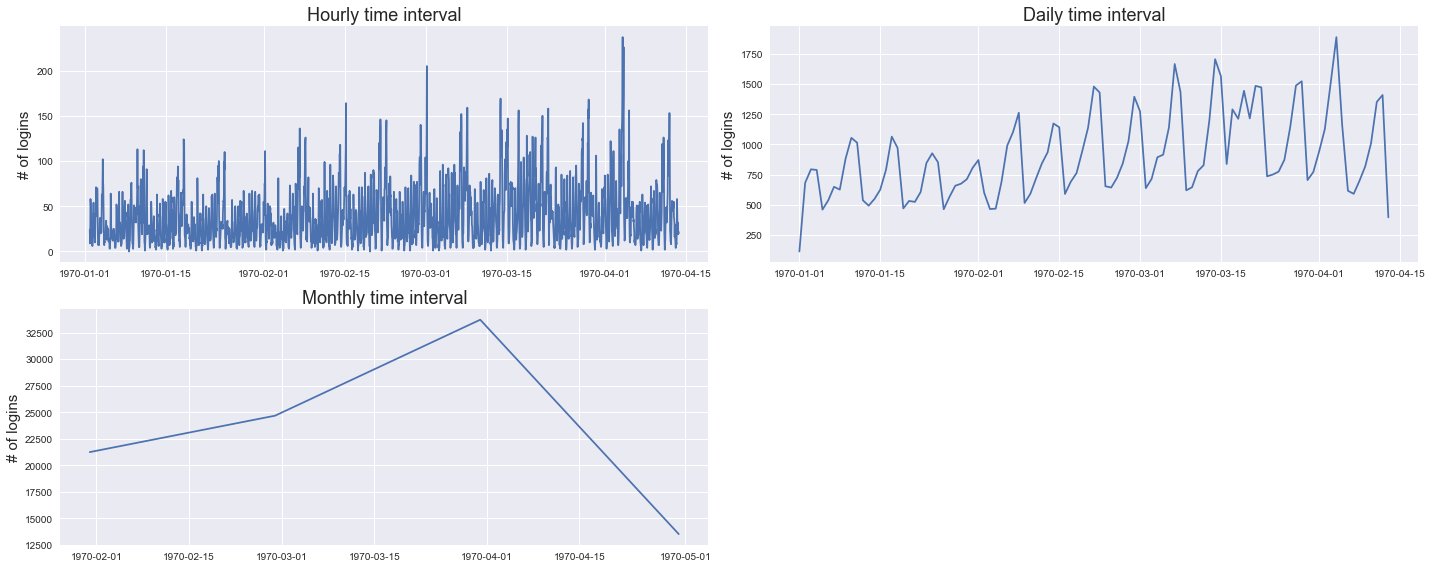

In [10]:
plt.rcParams['axes.labelsize'] = 15
plt.rcParams['axes.titlesize'] = 18
#resampling
hourly = resample(df, '60Min')
daily = resample(df, 'D')
monthly = resample(df, 'M')
plt.rcParams['figure.figsize'] = (20, 8)
# Hourly
custom_plot(hourly, 221, "Hourly time interval","# of logins")
# Daily
custom_plot(daily, 222, "Daily time interval", "# of logins")
# Monthly
custom_plot(monthly, 223, "Monthly time interval","# of logins")
plt.show()

#### Seasonality, Trend and Noise

Seasonal decomposition of the data over time to look for trends and patterns.

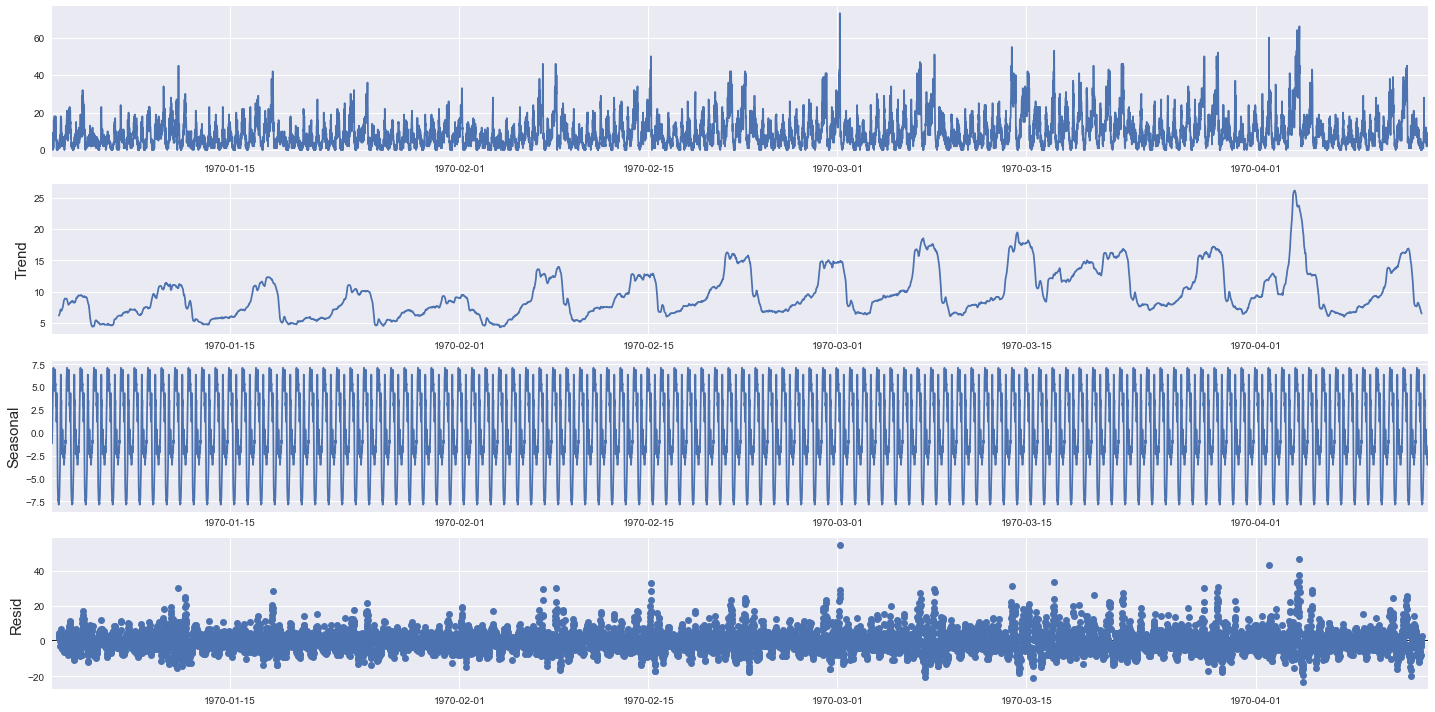

In [11]:
from statsmodels.tsa.seasonal import seasonal_decompose
plt.rcParams['figure.figsize'] = (20, 10)
result = seasonal_decompose(df, model='additive',period=96)
result.plot()
plt.show()

There is clearly a pattern to  logins over time. What is immediately apparent is a weekly trend to the login pattern and total logins are increasing over time. To get a closer look, let's check the daily and weekly patterns of logins by taking the mean across each over time.

In [12]:
#average each reading by hour of day across all days
daily = df.login.groupby(df.index.hour).mean()
#average each reading by day of week across all weeks
weekly = df.login.groupby(df.index.weekday).mean()
days = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday', 'Sunday']

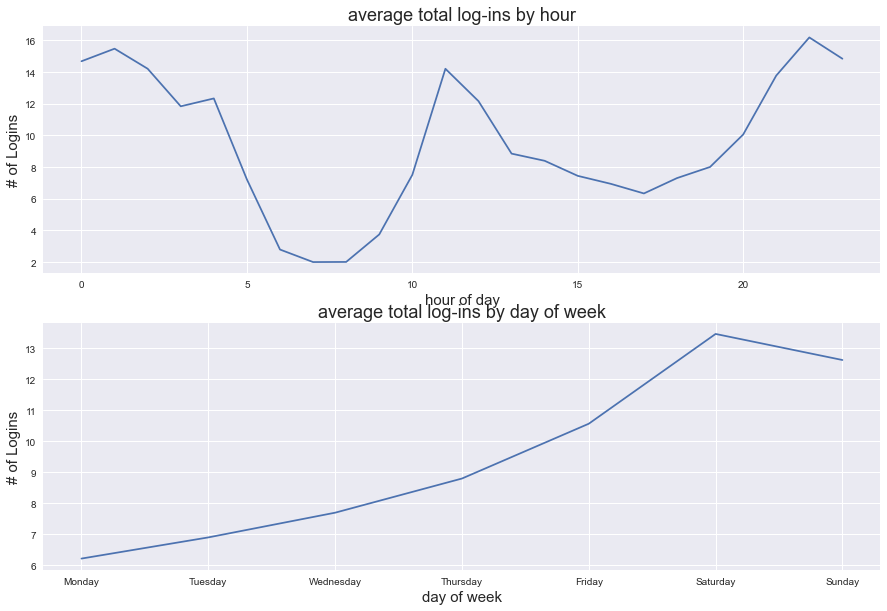

In [13]:
#plot
plt.figure(figsize=(15,10))
plt.subplot(2,1,1)
plt.plot(daily)
plt.title('average total log-ins by hour')
plt.xlabel('hour of day')
plt.ylabel('# of Logins')
plt.subplot(2,1,2)
plt.plot(weekly)
plt.xticks([0,1,2,3,4,5,6],days)
plt.title('average total log-ins by day of week')
plt.xlabel('day of week')
plt.ylabel('# of Logins')
plt.show()

From the above graphs we can clearly see daily and weekly trends in the number of logins. It's apparent logins hit their peak activity between 10am and 1pm and between 10pm and 4am.  There are very few logins starting around 4am until 10am. A second lull in logins appears between 1pm and 10pm. As for weekly trends, logins clearly increase as the week goes on peaking on Saturday and slowly dropping off on Sunday. In summation, daily demand is highest around noon and midnight and weekly demand is highest on the weekends.  

# Part 2: Experiment and metrics design


The neighboring cities of Gotham and Metropolis have complementary circadian rhythms: on
weekdays, Ultimate Gotham is most active at night, and Ultimate Metropolis is most active
during the day. On weekends, there is reasonable activity in both cities.
However, a toll bridge, with a two way
toll, between the two cities causes driver partners to tend
to be exclusive to each city. The Ultimate managers of city operations for the two cities have
proposed an experiment to encourage driver partners to be available in both cities, by
reimbursing all toll costs.
1. What would you choose as the key measure of success of this experiment in
encouraging driver partners to serve both cities, and why would you choose this metric?
2. Describe a practical experiment you would design to compare the effectiveness of the
proposed change in relation to the key measure of success. Please provide details on:
* how you will implement the experiment
* what statistical test(s) you will conduct to verify the significance of the
observation
* how you would interpret the results and provide recommendations to the city
operations team along with any caveats.

1. Key Metric of Success

I would choose the number of times drivers cross the bridge per night as the key measure of success for this experiment. It is the most obvious measure of success if Ultimate wants to increase the number of driver partners to be available in each city.  If the toll at the bridge is truly the only reason why partners aren't available in each city, then the number of crossings should increase after the reimbursement program.    

2. Describe a practical experiment you would design to compare the effectiveness of the proposed change in relation to the key measure of success. 
* How will you implement the experiment?

Implementing this experiment would be relatively easy. First, randomly sample partner drivers into two groups: partners with no reimbursement (control group) and partners with reimbursement (experimental group). Then track the number of bridge crossings per night between the two groups. 


* What statistical test(s) you will conduct to verify the significance of the observation?

We would use a hypothesis test comparing the number of bridge crossings for the control group and the number of bridge crossings for the experimental group. The null hypothesis would be: There is no statistically significant difference of the number of bridge crossings between the control and experimental groups. Testing the null-hypothesis should be as simple as comparing the control and experimental groups with a t-test to compare the means of the groups. If we find the experimental group is significantly different from the control, we will reject the null hypothesis. 

* How you would interpret the results and provide recommendations to the city operations team along with any caveats?

If we find the experimental group is significantly different from the control, we will reject the null hypothesis and can assume the reimbursement program was a success in encouraging partner drivers to be available in both cities. Although, I would recommend running the experiment several times to be on the safe side. I might also bring to attention other factors resulting in the significant difference between the two groups. Was our random sample truly random? Perhaps by chance, the experimental group included drivers that regularly crossed the bridge before the reimbursement program. In that case, we might want to set up our experiment in a different way. Instead of separating the partners into control and experimental groups, we could instead include all partners in the reimbursement program and compare bridge crossings before the program and after. 


If we cannot reject the null hypothesis then we must assume one of two possibilities: 
1. there is another factor besides paying the toll that discourages partners from being available in each city 
or 
2. The key metric of success is incorrect. 

In the first case Ultimate might want to develop another experiment to determine the root cause of partners not wanting to cross the bridge.  Perhaps it's because they don't want to drive too far from home or they find it a hassle to cross the bridge. More research would need to be done in order to find a satisfactory answer. In the second case, we would have to set up a new experiment with a different measure of success.    


     

# Part 3: Predictive Modeling

Ultimate is interested in predicting rider retention. To help explore this question, we have
provided a sample dataset of a cohort of users who signed up for an Ultimate account in
January 2014. The data was pulled several months later; we consider a user retained if they
were “active” (i.e. took a trip) in the preceding 30 days.
We would like you to use this data set to help understand what factors are the best predictors
for retention, and offer suggestions to operationalize those insights to help Ultimate.
The data is in the attached file ultimate_data_challenge.json. See below for a detailed
description of the dataset. Please include any code you wrote for the analysis and delete the
dataset when you have finished with the challenge.
1. Perform any cleaning, exploratory analysis, and/or visualizations to use the provided
data for this analysis (a few sentences/plots describing your approach will suffice). What
fraction of the observed users were retained?
2. Build a predictive model to help Ultimate determine whether or not a user will be active
in their 6th month on the system. Discuss why you chose your approach, what
alternatives you considered, and any concerns you have. How valid is your model?
Include any key indicators of model performance.
3. Briefly discuss how Ultimate might leverage the insights gained from the model to
improve its longterm
rider retention (again, a few sentences will suffice).

## EDA

In [14]:
# Import data
df_2 = pd.read_json('ultimate_data_challenge.json')
df_2

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9
...,...,...,...,...,...,...,...,...,...,...,...,...
49995,King's Landing,0,2014-01-25,5.0,1.00,2014-06-05,iPhone,0.0,False,100.0,5.63,4.2
49996,Astapor,1,2014-01-24,NaN,1.00,2014-01-25,iPhone,0.0,False,0.0,0.00,4.0
49997,Winterfell,0,2014-01-31,5.0,1.00,2014-05-22,Android,0.0,True,100.0,3.86,5.0
49998,Astapor,2,2014-01-14,3.0,1.00,2014-01-15,iPhone,0.0,False,100.0,4.58,3.5


In [15]:
df_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   signup_date             50000 non-null  object 
 3   avg_rating_of_driver    41878 non-null  float64
 4   avg_surge               50000 non-null  float64
 5   last_trip_date          50000 non-null  object 
 6   phone                   49604 non-null  object 
 7   surge_pct               50000 non-null  float64
 8   ultimate_black_user     50000 non-null  bool   
 9   weekday_pct             50000 non-null  float64
 10  avg_dist                50000 non-null  float64
 11  avg_rating_by_driver    49799 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


We can see we have missing values in 3 columns: avg_rating_by_driver, phone, and avg_rating_of_driver. 

In [16]:
# Fill missing values in avg_rating_by_driver and avg_rating_of_driver
df_2.avg_rating_of_driver.fillna(df_2.avg_rating_of_driver.mean(),inplace=True)
df_2.avg_rating_by_driver.fillna(df_2.avg_rating_by_driver.mean(),inplace=True)
# Fill missing phone numbers with n/a
df_2.phone.fillna('n/a',inplace=True)

In [17]:
df_2.describe()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver
count,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,2.278200,4.601559,1.074764,8.849536,60.926084,5.796827,4.778158
std,3.792684,0.564977,0.222336,19.958811,37.081503,5.707357,0.445753
min,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,4.500000,1.000000,0.000000,33.300000,2.420000,4.700000
50%,1.000000,4.700000,1.000000,0.000000,66.700000,3.880000,5.000000
75%,3.000000,5.000000,1.050000,8.600000,100.000000,6.940000,5.000000
max,125.000000,5.000000,8.000000,100.000000,100.000000,160.960000,5.000000


In order to find the percent of users retained, we need to convert all of the columns with dates into datetime objects.

In [18]:
df_2.last_trip_date = pd.to_datetime(df_2.last_trip_date)
df_2.signup_date  = pd.to_datetime(df_2.signup_date)

In [19]:
print(df_2.last_trip_date.max())
df_2.last_trip_date.max() -  pd.to_timedelta(30, unit='d')

2014-07-01 00:00:00


Timestamp('2014-06-01 00:00:00')

In [20]:
#encode target variable 'active' as true or false for last trip in june
df_2['active'] = [1 if x.month >= 6 else 0 for x in df_2.last_trip_date]
print(f"Fraction of active users: {sum(df_2.active)/len(df_2.active)}")

Fraction of active users: 0.37608


In [21]:
df_2.columns

Index(['city', 'trips_in_first_30_days', 'signup_date', 'avg_rating_of_driver',
       'avg_surge', 'last_trip_date', 'phone', 'surge_pct',
       'ultimate_black_user', 'weekday_pct', 'avg_dist',
       'avg_rating_by_driver', 'active'],
      dtype='object')

### Explore data relationships

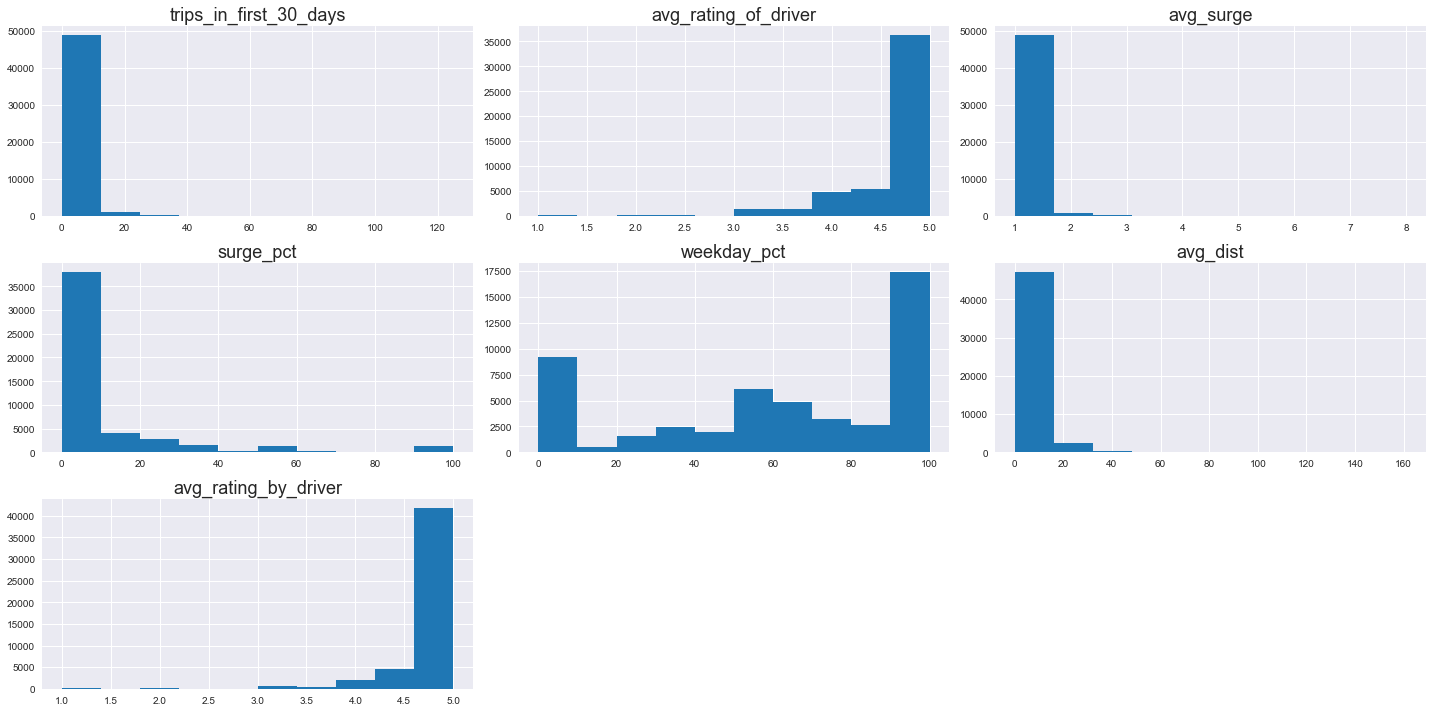

In [22]:
# Plot histogram of select variables 
df_2.hist(column=['trips_in_first_30_days','avg_rating_of_driver','avg_surge','surge_pct','weekday_pct','avg_dist','avg_rating_by_driver'],color='tab:blue')
plt.tight_layout()
plt.show()

We can see the vast moajority of ratings by driver and rating of driver are 4 or 5 stars. Also, the majority of average distance is less than 20 miles.  It appears users either use Ultimate close to 100% of the time on the weekday or close to 0%. 

#### Anomalies and Outliers 

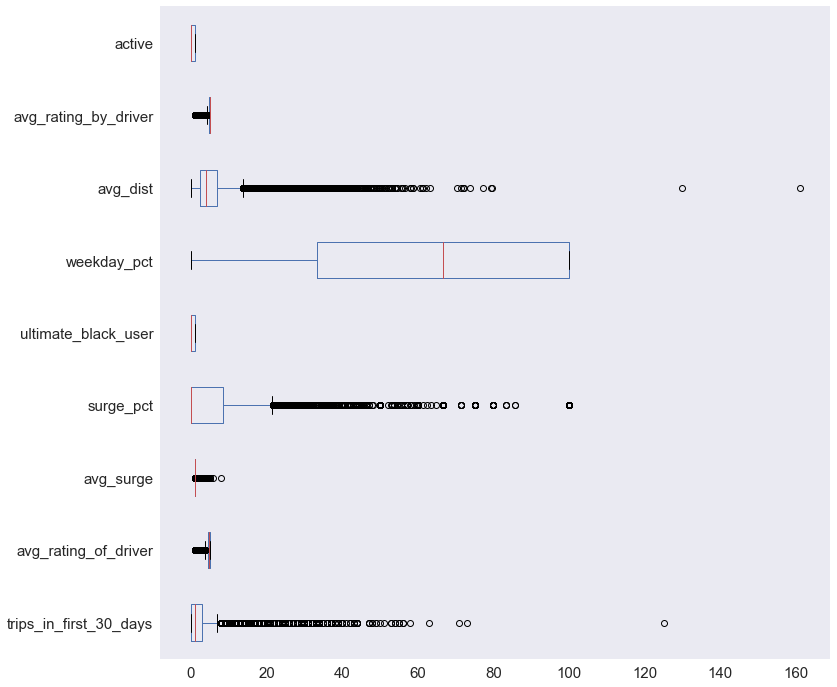

In [23]:
boxplot = df_2.boxplot(grid=False, vert=False,fontsize=15,figsize=(12,12))

From the boxplot above, it's apparent there are several outliers in average distance and trips in the first 30 days. 

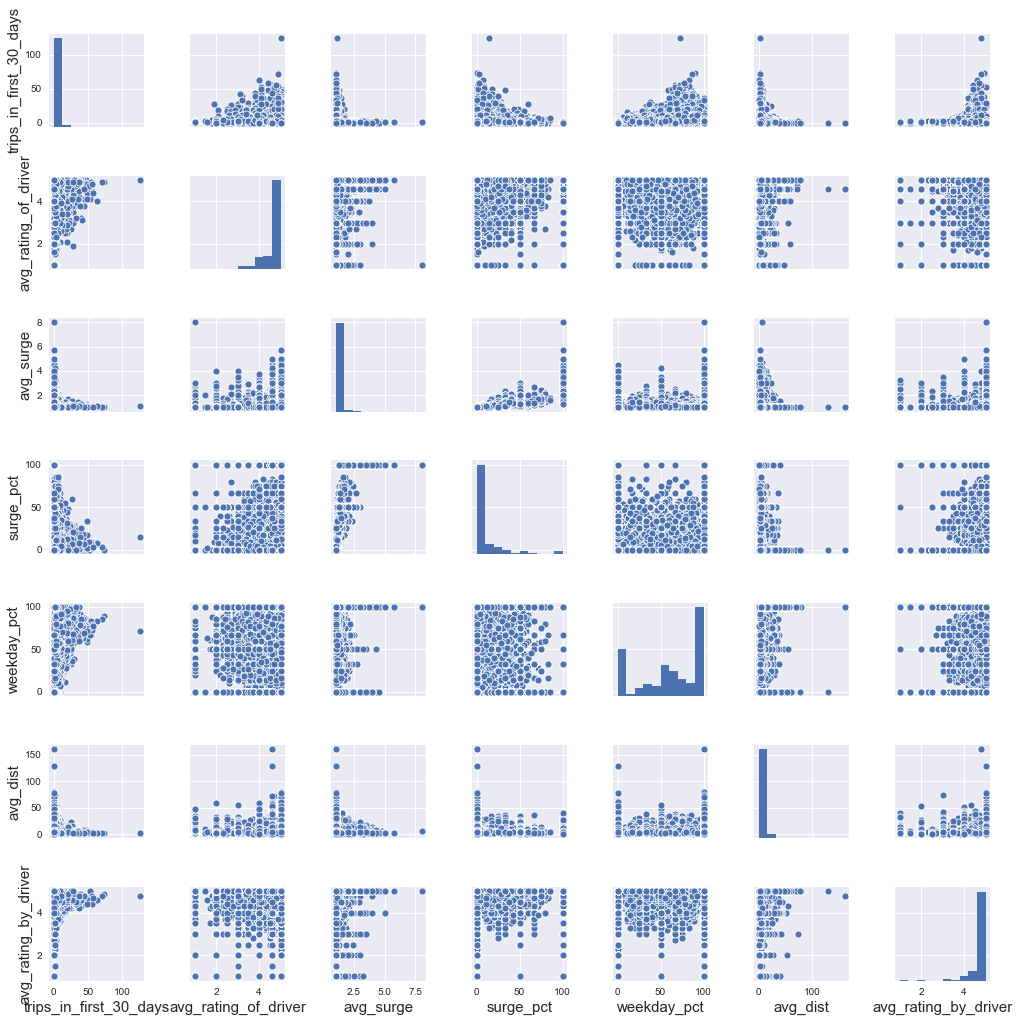

In [24]:
# Create a pairplot with only continuous variables. 
pair_plot = df_2.drop(['city','signup_date','last_trip_date', 'phone','ultimate_black_user','active'],axis=1)
sns_plot = sns.pairplot(pair_plot, height=2.0)

In [25]:
# Create a correlation matrix
corr = df_2.corr(method ='pearson')
#plot it in the next line
corr.round(2).style.background_gradient(cmap='coolwarm')

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,active
trips_in_first_30_days,1.000000,-0.010000,-0.000000,0.010000,0.110000,0.050000,-0.140000,-0.040000,0.210000
avg_rating_of_driver,-0.010000,1.000000,-0.020000,-0.000000,-0.000000,0.010000,0.030000,0.100000,-0.010000
avg_surge,-0.000000,-0.020000,1.000000,0.790000,-0.080000,-0.110000,-0.080000,0.010000,-0.000000
surge_pct,0.010000,-0.000000,0.790000,1.000000,-0.110000,-0.140000,-0.100000,0.020000,0.010000
ultimate_black_user,0.110000,-0.000000,-0.080000,-0.110000,1.000000,0.040000,0.030000,0.010000,0.210000
weekday_pct,0.050000,0.010000,-0.110000,-0.140000,0.040000,1.000000,0.100000,0.020000,0.010000
avg_dist,-0.140000,0.030000,-0.080000,-0.100000,0.030000,0.100000,1.000000,0.080000,-0.090000
avg_rating_by_driver,-0.040000,0.100000,0.010000,0.020000,0.010000,0.020000,0.080000,1.000000,-0.030000
active,0.210000,-0.010000,-0.000000,0.010000,0.210000,0.010000,-0.090000,-0.030000,1.000000


From the plot above it is apparent that some of the variables correlate with one another. Particularly active users and trips within the first 30 days. Unsurprisingly, average surge and surge percent correlate with each other as well. 

## Predictive Modeling

Since we are trying to determine whether or not a user is retained after six months, this is a classification problem. We will use Logistic Regression, K Nearest neighbors classifier, support vector machine, and Random Forest Classifier.  SVC fairs better with higher dimensional data, while RandomForestClassifier is susceptible to high levels of noise. We can try all of them and see which one performs best. 

In [26]:
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import classification_report, plot_confusion_matrix,confusion_matrix, roc_auc_score, roc_curve, accuracy_score, precision_score, recall_score,f1_score, precision_recall_curve
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
import scikitplot as skplt

In [27]:
# Create Datframe to compare models
metrics = pd.DataFrame(index=['accuracy', 'precision', 'recall','F1', 'AUC',], 
                       columns=['Dummy Model', 'Logistic Regression', 'K Nearest Neighbors', 'Support Vector Machine', 'Random Forest',])

#### One hot encode discrete variables 

In [28]:
df_2 = pd.get_dummies(df_2)


#### Split data into train and test

In [29]:
# separate dependent and independent variables 
X = df_2.drop(['active','last_trip_date','signup_date'], axis=1)
y = df_2.active.values
#split 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=9)

#### Scale Data to Prep for Model Creation

In [30]:
#scale data
# build scaler based on training data
scaler = StandardScaler().fit(X_train)
X_train_scaled=scaler.transform(X_train)
X_test_scaled=scaler.transform(X_test)

#### Build Models

In [31]:
# Create Dummy Classifier as a comparison tool
dum = DummyClassifier(strategy='most_frequent', random_state=0)
dum.fit(X_train_scaled, y_train)
y_pred_dum = dum.predict(X_test_scaled)
y_pred_dum_p = dum.predict_proba(X_test_scaled)[::,1]
print(classification_report(y_test,y_pred_dum))
print(f"ROC_AUC:{roc_auc_score(y_test,y_pred_dum_p)}")
metrics.loc['accuracy','Dummy Model'] =accuracy_score(y_test,y_pred_dum)
metrics.loc['precision','Dummy Model'] = precision_score(y_test,y_pred_dum)
metrics.loc['recall','Dummy Model'] = recall_score(y_test,y_pred_dum)
metrics.loc['F1','Dummy Model'] = f1_score(y_test,y_pred_dum)
metrics.loc['AUC','Dummy Model'] = roc_auc_score(y_test,y_pred_dum_p)

              precision    recall  f1-score   support

           0       0.62      1.00      0.77      7794
           1       0.00      0.00      0.00      4706

    accuracy                           0.62     12500
   macro avg       0.31      0.50      0.38     12500
weighted avg       0.39      0.62      0.48     12500

ROC_AUC:0.5


C:\Users\public\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\public\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


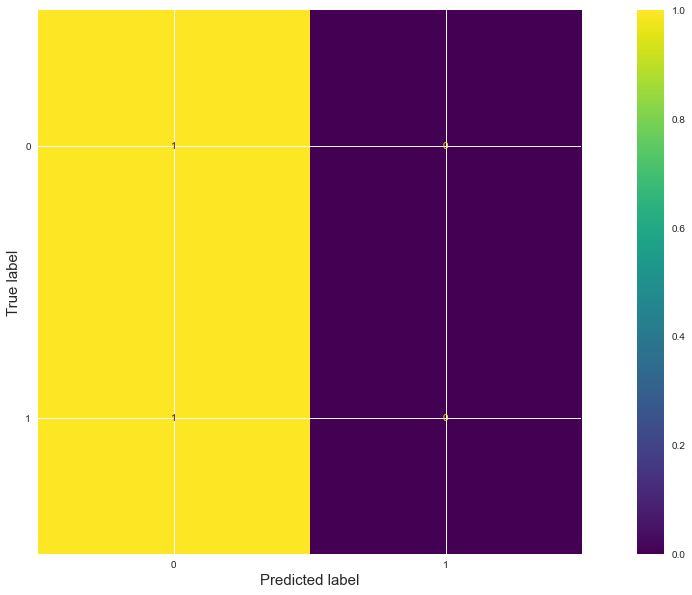

<Figure size 576x576 with 0 Axes>

In [32]:
# Plot Confsion Matrix 
plot_confusion_matrix(dum, X_test_scaled, y_test,normalize='true')
plt.figure(figsize=(8,8))
plt.show()

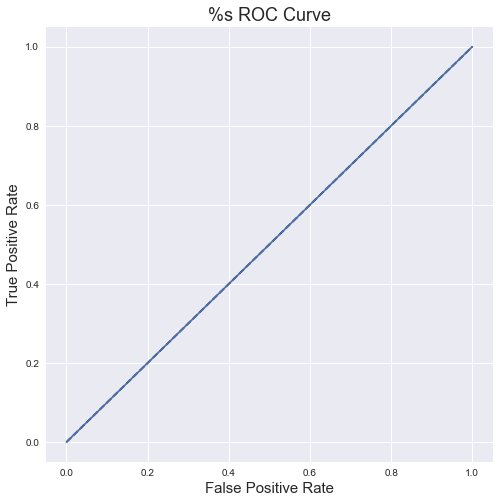

In [33]:
fpr, tpr, thresholds  = roc_curve(y_test, y_pred_dum_p)
plt.figure(figsize=(8,8))
plt.plot([0,1], [0,1], 'k--')
plt.plot(fpr, tpr, label='Dummy Model')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('%s ROC Curve')
plt.show()

In [34]:
# K nearest neighbors
#knn = KNeighborsClassifier() 

#specify a parameter grid to search over
#parameters_knn = {
   # 'n_neighbors': [10, 13, 15],
    #'weights': ['uniform', 'distance'],
    #'metric': ['euclidean', 'manhattan', 'minkowski'],
#}

#knn_cv = GridSearchCV(knn, parameters_knn, cv=5) #specify GridSearchCV object

#knn_cv.fit(X_train_scaled, y_train) #fit to training data
# Report the best parameters and the corresponding score
#print("Best CV params", knn_cv.best_params_)
#print("Best CV accuracy", knn_cv.best_score_)

# Report the test accuracy using these best parameters
#print("Test accuracy of best grid search hypers:", knn_cv.score(X_test_scaled, y_test))


In [35]:
# Use best parameters to build model
knn = KNeighborsClassifier(metric='manhattan',n_neighbors=15,weights='uniform')
knn.fit(X_train_scaled, y_train)
y_pred_knn = knn.predict(X_test_scaled)
y_pred_knn_p = knn.predict_proba(X_test_scaled)[:,1]
print(classification_report(y_test,y_pred_knn))
print(f"ROC_AUC:{roc_auc_score(y_test,y_pred_knn_p)}")
metrics.loc['accuracy','K Nearest Neighbors'] =accuracy_score(y_test,y_pred_knn)
metrics.loc['precision','K Nearest Neighbors'] = precision_score(y_test,y_pred_knn)
metrics.loc['recall','K Nearest Neighbors'] = recall_score(y_test,y_pred_knn)
metrics.loc['F1','K Nearest Neighbors'] = f1_score(y_test,y_pred_knn)
metrics.loc['AUC','K Nearest Neighbors'] = roc_auc_score(y_test,y_pred_knn_p)

              precision    recall  f1-score   support

           0       0.79      0.85      0.82      7794
           1       0.72      0.62      0.67      4706

    accuracy                           0.77     12500
   macro avg       0.75      0.74      0.74     12500
weighted avg       0.76      0.77      0.76     12500

ROC_AUC:0.8210183882880475


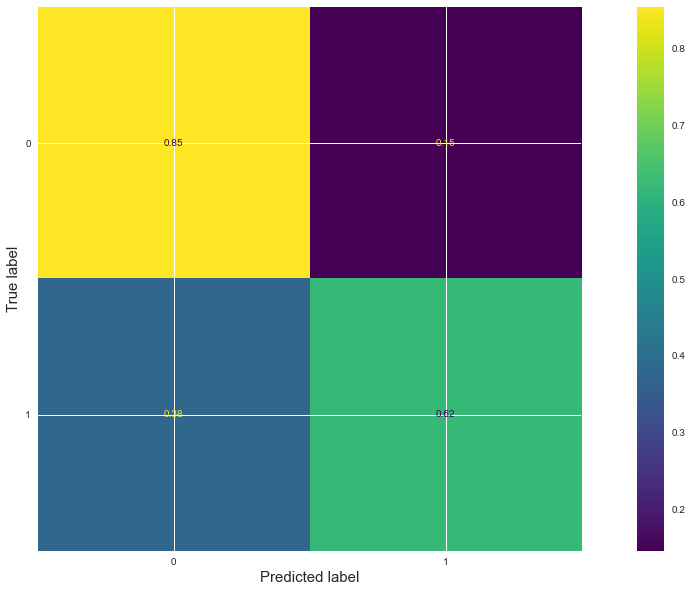

<Figure size 576x576 with 0 Axes>

In [36]:
# Plot Confsion Matrix and ROC Curve
plot_confusion_matrix(knn, X_test_scaled, y_test,normalize='true')
plt.figure(figsize=(8,8))
plt.show()

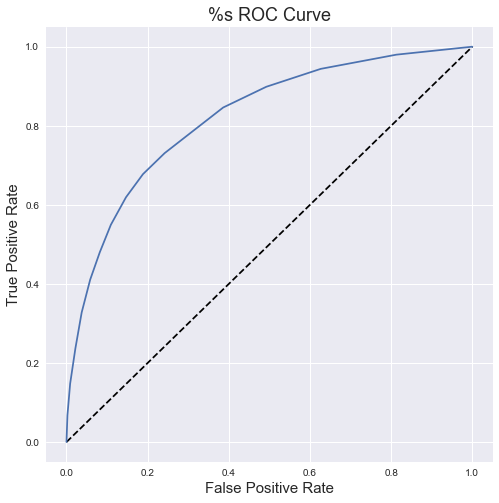

In [37]:
fpr, tpr, thresholds  = roc_curve(y_test, y_pred_knn_p)
plt.figure(figsize=(8,8))
plt.plot([0,1], [0,1], 'k--')
plt.plot(fpr, tpr, label='KNN')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('%s ROC Curve')
plt.show()

In [38]:
# Logistic Regression 
#lr = LogisticRegression() 

#specify a parameter grid to search over
#parameters_lr = {
   # 'C': np.logspace(-5, 8, 15),
   # }

#lr_cv = GridSearchCV(lr, parameters_lr, cv=5) #specify GridSearchCV object

#lr_cv.fit(X_train_scaled, y_train) #fit to training data
# Report the best parameters and the corresponding score
#print("Best CV params", lr_cv.best_params_)
#print("Best CV accuracy", lr_cv.best_score_)

# Report the test accuracy using these best parameters
#print("Test accuracy of best grid search hypers:", lr_cv.score(X_test_scaled, y_test))

In [39]:
# Use best parameters to build model
lr = LogisticRegression(C=0.0007196856730011522) 
lr.fit(X_train_scaled, y_train)
y_pred_lr = lr.predict(X_test_scaled)
y_pred_lr_p = lr.predict_proba(X_test_scaled)[::,1]
print(classification_report(y_test,y_pred_lr))
print(f"ROC_AUC:{roc_auc_score(y_test,y_pred_lr_p)}")
metrics.loc['accuracy','Logistic Regression'] =accuracy_score(y_test,y_pred_lr)
metrics.loc['precision','Logistic Regression'] = precision_score(y_test,y_pred_lr)
metrics.loc['recall','Logistic Regression'] = recall_score(y_test,y_pred_lr)
metrics.loc['F1','Logistic Regression'] = f1_score(y_test,y_pred_lr)
metrics.loc['AUC','Logistic Regression'] = roc_auc_score(y_test,y_pred_lr_p)

              precision    recall  f1-score   support

           0       0.73      0.86      0.79      7794
           1       0.67      0.46      0.54      4706

    accuracy                           0.71     12500
   macro avg       0.70      0.66      0.67     12500
weighted avg       0.70      0.71      0.70     12500

ROC_AUC:0.7525805808537107


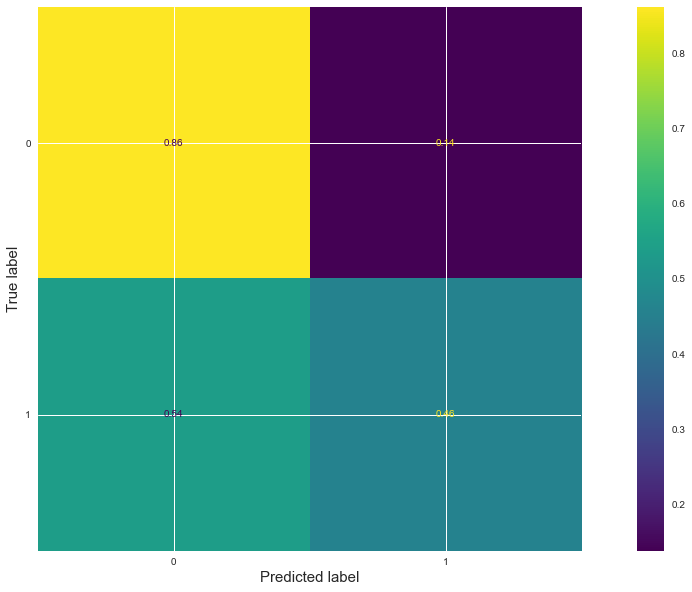

<Figure size 576x576 with 0 Axes>

In [40]:
# Plot Confsion Matrix and ROC Curve
plot_confusion_matrix(lr, X_test_scaled, y_test,normalize='true')
plt.figure(figsize=(8,8))
plt.show()


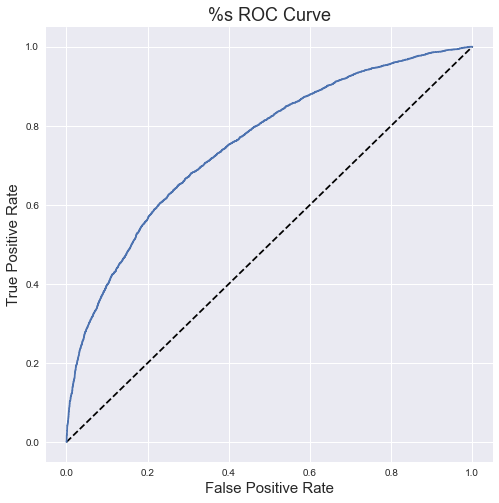

In [41]:
fpr, tpr, thresholds  = roc_curve(y_test, y_pred_lr_p)
plt.figure(figsize=(8,8))
plt.plot([0,1], [0,1], 'k--')
plt.plot(fpr, tpr, label='Logistic Regression')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('%s ROC Curve')
plt.show()

In [42]:
# Support vector Machine 
#svm = SVC() 

#specify a parameter grid to search over
#parameters_svm = {
   # 'C': [0.1, 1, 10,],
   # 'gamma': [1, 0.1, 0.01]
#}

#svm_cv = GridSearchCV(svm, parameters_svm,verbose=3,n_jobs=-1, cv=5) #specify GridSearchCV object

#svm_cv.fit(X_train_scaled, y_train) #fit to training data
# Report the best parameters and the corresponding score
#print("Best CV params", svm_cv.best_params_)
#print("Best CV accuracy", svm_cv.best_score_)

# Report the test accuracy using these best parameters
#print("Test accuracy of best grid search hypers:", svm_cv.score(X_test_scaled, y_test))

In [43]:
svm = SVC(C=10,gamma=.1)
svm.fit(X_train_scaled, y_train)
y_pred_svm = svm.predict(X_test_scaled)
print(classification_report(y_test,y_pred_svm))
metrics.loc['accuracy','Support Vector Machine'] =accuracy_score(y_test,y_pred_svm)
metrics.loc['precision','Support Vector Machine'] = precision_score(y_test,y_pred_svm)
metrics.loc['recall','Support Vector Machine'] = recall_score(y_test,y_pred_svm)
metrics.loc['F1','Support Vector Machine'] = f1_score(y_test,y_pred_svm)

              precision    recall  f1-score   support

           0       0.79      0.86      0.82      7794
           1       0.73      0.63      0.67      4706

    accuracy                           0.77     12500
   macro avg       0.76      0.74      0.75     12500
weighted avg       0.77      0.77      0.77     12500



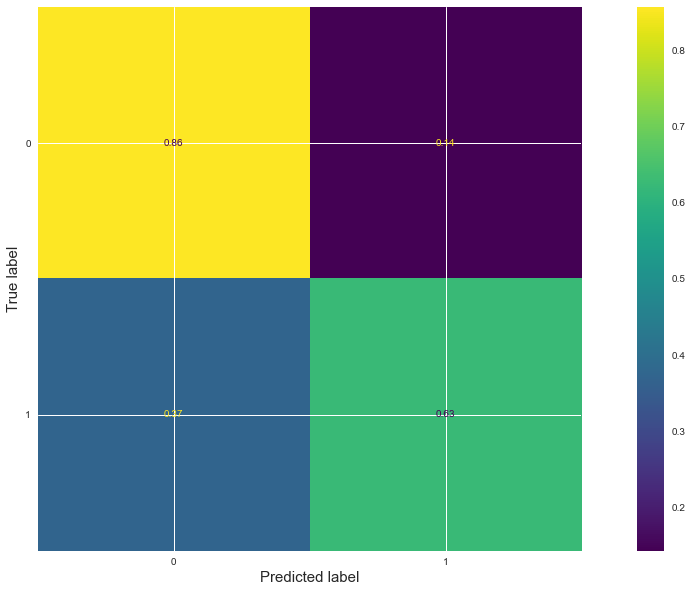

<Figure size 576x576 with 0 Axes>

In [44]:
# Plot Confsion Matrix and ROC Curve
plot_confusion_matrix(svm, X_test_scaled, y_test,normalize='true')
plt.figure(figsize=(8,8))
plt.show()

In [45]:
# Random forest Classifier
#rf = RandomForestClassifier() 

#specify a parameter grid to search over
#parameters_rf = {
                # 'n_estimators': [50, 100],
                # 'criterion': ["gini", "entropy"],
                # 'max_depth': [3, 10, 20, None],
                # 'min_samples_leaf': [1,2,3,4,5,6,7,8,9],
                # 'max_features': [1,2,3,4,5,6,7,8,9]
#}
#rf_cv = GridSearchCV(rf, parameters_rf,verbose=3, n_jobs=-1,cv=5) #specify GridSearchCV object

#rf_cv.fit(X_train_scaled, y_train) #fit to training data
# Report the best parameters and the corresponding score
#print("Best CV params", rf_cv.best_params_)
#print("Best CV accuracy", rf_cv.best_score_)

# Report the test accuracy using these best parameters
#print("Test accuracy of best grid search hypers:", rf_cv.score(X_test_scaled, y_test))

In [46]:
# Use best parameters to build model
rf = RandomForestClassifier(criterion='entropy',max_depth=20,max_features=3,min_samples_leaf=9,n_estimators=100) 
rf.fit(X_train_scaled, y_train)
y_pred_rf = rf.predict(X_test_scaled)
y_pred_rf_p = rf.predict_proba(X_test_scaled)[:,1]
print(classification_report(y_test,y_pred_rf))
print(f"ROC_AUC:{roc_auc_score(y_test,y_pred_rf_p)}")
metrics.loc['accuracy','Random Forest'] =accuracy_score(y_test,y_pred_rf)
metrics.loc['precision','Random Forest'] = precision_score(y_test,y_pred_rf)
metrics.loc['recall','Random Forest'] = recall_score(y_test,y_pred_rf)
metrics.loc['F1','Random Forest'] = f1_score(y_test,y_pred_rf)
metrics.loc['AUC','Random Forest'] = roc_auc_score(y_test,y_pred_rf_p)

              precision    recall  f1-score   support

           0       0.81      0.87      0.84      7794
           1       0.75      0.66      0.70      4706

    accuracy                           0.79     12500
   macro avg       0.78      0.76      0.77     12500
weighted avg       0.79      0.79      0.78     12500

ROC_AUC:0.8518183808940829


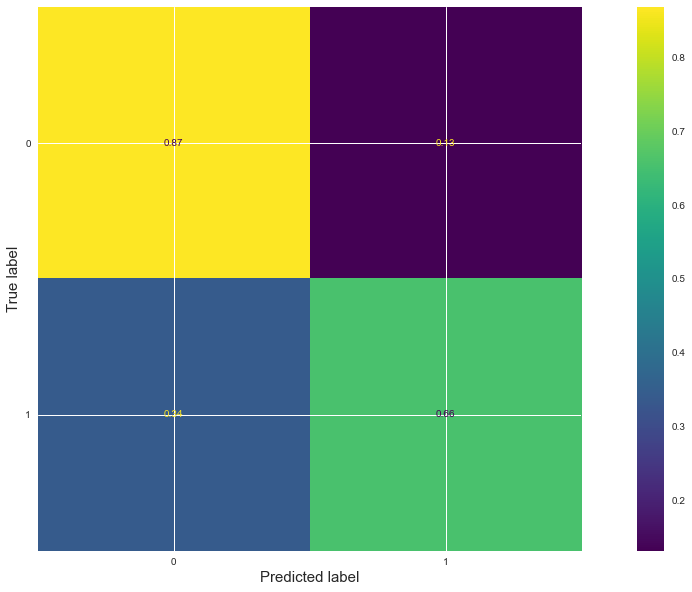

<Figure size 576x576 with 0 Axes>

In [47]:
# Plot Confsion Matrix and ROC Curve
plot_confusion_matrix(rf, X_test_scaled, y_test,normalize='true')
plt.figure(figsize=(8,8))
plt.show()

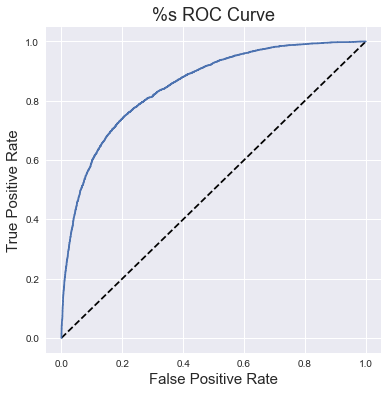

In [48]:
fpr, tpr, thresholds  = roc_curve(y_test, y_pred_rf_p)
plt.figure(figsize=(6,6))
plt.plot([0,1], [0,1], 'k--')
plt.plot(fpr, tpr, label='Random Forest')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('%s ROC Curve')
plt.show()

#### Compare models

In [49]:
metrics = metrics*100
metrics

,Dummy Model,Logistic Regression,K Nearest Neighbors,Support Vector Machine,Random Forest
accuracy,62.352,71.056,76.52,77.016,78.776
precision,0,66.8005,71.8265,72.5683,74.909
recall,0,45.9626,61.921,62.6222,65.5971
F1,0,54.4562,66.5069,67.2294,69.9445
AUC,50,75.2581,82.1018,NaN,85.1818


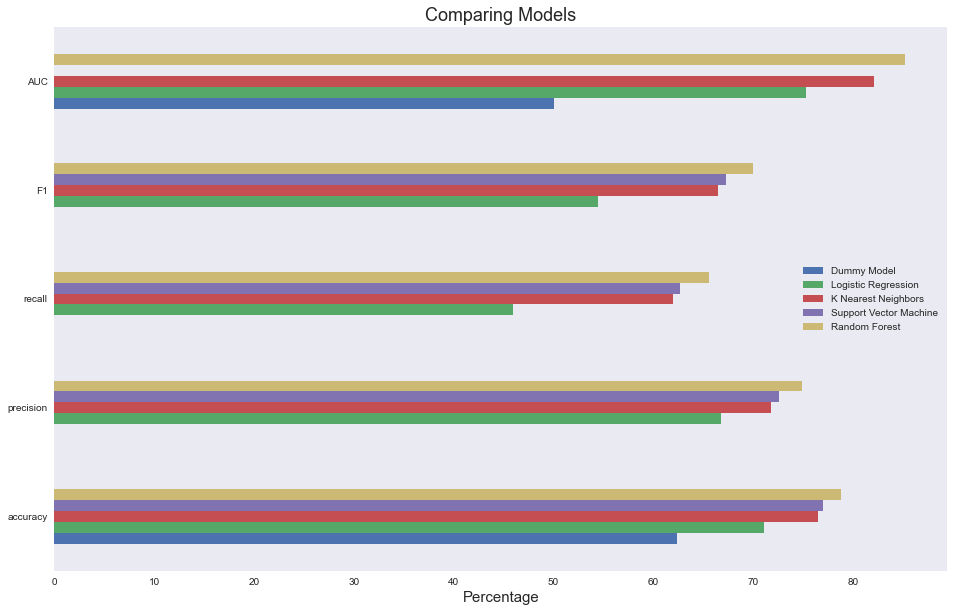

In [50]:
fig, ax = plt.subplots(figsize=(16,10))
metrics.plot(kind='barh', ax=ax)
ax.set_xlabel('Percentage')
ax.set_title('Comparing Models')
ax.grid();


After comparing all of the models its clear the random forest model is the best, with an accuracy of 78%. This is around 16% better than the Dummy Model which predicts the user was not retained for every user. This is a significant improvement. In addition to having the highest accuracy of any model, we also see that is has the best AUC score of any model, as well as, the highest precision and recall scores. 


We have built several classification models to predict whether customers will be retained or not using the most common classification algorithms. We chose a Random Forest model to be our model for prediction because it produced superior accuracy and AUC scores to all of the other classification models we used.

In terms of any concerns we have, the biggest concern would be that we might value false negative more highly than false positives or vice-versa. In that case, we would want to adjust the probability threshold for classification to reflect that. In any case, Random Forest remains the best model due to it having the best precision-recall curve of any model.

In terms of model validity, our model is only as accurate as the input data. Also, our model is only as good as we the degree to which we know how to use it. That goes back to the point about precion-recall. First we have to know which we care about more before we can use our model optimally.

In order to leverage the insights from this model to improve longterm rider retention, it's necessary to look into the most important features contributing to user retention. Let's take a look now.



#### Random Forest most important features

14


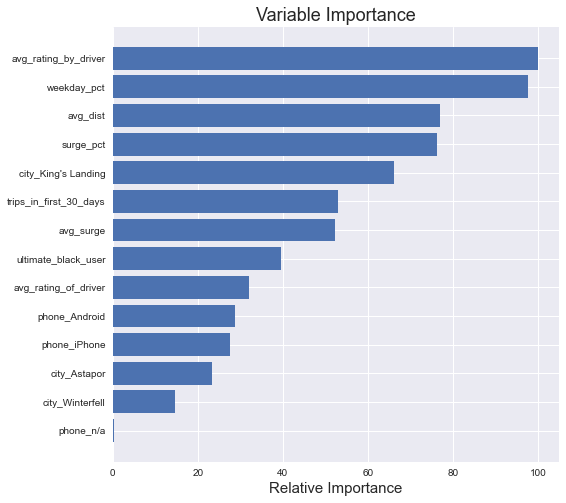

In [51]:
feature_importance = rf.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
print(pos.size)
sorted_idx.size
plt.figure(figsize=(8,8))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

We can see the top three features are average rating by driver, weekday percent, and average disance. Let's see how these variabels are correlated with the target varibale. 

In [52]:
# Show correlations with target variable
print(df_2['avg_rating_by_driver'].corr(df_2['active']))
print(df_2['weekday_pct'].corr(df_2['active']))
print(df_2['avg_dist'].corr(df_2['active']))


-0.026748042806069867
0.009692972843291937
-0.09277986324064347


In [53]:
# Show average rating for retained and non retained users.
df_retained = df_2[df_2['active']==1]
df_non_retained = df_2[df_2['active']==0]
print(f"Average rating by driver for retained users: {df_retained['avg_rating_by_driver'].mean()}")
print(f"Average rating by driver for non-retained users: {df_non_retained['avg_rating_by_driver'].mean()}")

Average rating by driver for retained users: 4.762801196290921
Average rating by driver for non-retained users: 4.787414928270617


It's interesting the most important variable determining retention is negatively correlated with the target variable. This implies users with poorer ratings from drivers are more likely to be retained. Maybe this has to do with the amount of fun a user is having in the ride. A user who might be obnoxious or overly comfortable during their ride might receive a poor rating from the driver. This could also be due to the expected tip from a user. Possibly young party-goers receive poor ratings from drivers but continue to use the service because they ease of use and the perceived hassle of using a taxi or competing service. All that being said, the difference in rating between reatined and non-retained users is only .02 of a star. 

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001D118A5BB88>]],
      dtype=object)

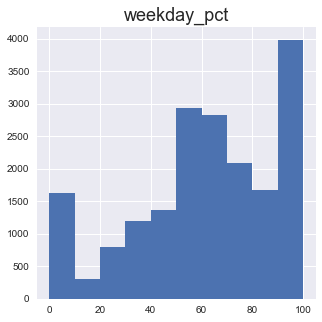

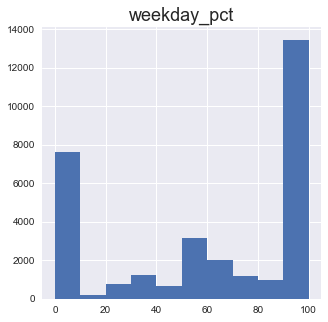

In [54]:
# Plot distribution of retained vs. non-retained by weekday pct
df_retained.hist(column='weekday_pct',figsize=(5,5))
df_non_retained.hist(column='weekday_pct',figsize=(5,5))

The next most important feature is the percent of the user’s trips occurring during a weekday. We see that the non-retained user distribution shows far more users who either only use it on the weekend, or only use it during the week. The actionable insight here would for Ultimate to target users who experience no difference in their need for transportation between the week and the weekend.

In [55]:
# Show average rating for retained and non retained users.
print(f"Average distance for retained users:{df_retained['avg_dist'].mean()}")
print(f"Average distance for non-retained users: {df_non_retained['avg_dist'].mean()}")

Average distance for retained users:5.114788342905812
Average distance for non-retained users: 6.207938517758687


Next, the third most important feature is average distance per trip. We can see the average distance for retained users is over a mile shorter than non-retained users. Ultimate could offer users who normally travel long distances a "short ride" discount in hopes to retain more of the users who only use the service for longer trips. 